# Influence Functions (MNIST rm bottom100)

In [0]:
#Keras CNN Training

from __future__ import print_function
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


In [0]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 10s 167us/step - loss: 0.2605 - acc: 0.9191 - val_loss: 0.0547 - val_acc: 0.9816
Epoch 2/12
60000/60000 [==============================] - 5s 75us/step - loss: 0.0903 - acc: 0.9733 - val_loss: 0.0464 - val_acc: 0.9845
Epoch 3/12
60000/60000 [==============================] - 5s 75us/step - loss: 0.0683 - acc: 0.9799 - val_loss: 0.0395 - val_acc: 0.9860
Epoch 4/12
60000/60000 [==============================] - 5s 75us/step - loss: 0.0539 - acc: 0.9835 - val_loss: 0.0331 - val_acc: 0.9885
Epoch 5/12
60000/60000 [===

In [0]:
y_pred = model.output #Or model.layers[index].output

In [0]:
model.output.shape

TensorShape([Dimension(None), Dimension(10)])

In [0]:
model.loss

<function keras.losses.categorical_crossentropy>

In [0]:
model.save('mnist_cnn.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [0]:
model = load_model('mnist_cnn.h5')

In [0]:
#@title `DarkonLogger` Definition
import logging
from logging.handlers import RotatingFileHandler


class DarkonLogger:
    """ darkon package logger
    """
    def __init__(self):
        _formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)-4s: %(message)s')
        # _file_handler = logging.handler.FileHandler(__package__ + '.log')
        _file_handler = RotatingFileHandler('darkon.log', maxBytes=1024*1024*100)
        _file_handler.setFormatter(_formatter)
        _file_handler.setLevel(logging.DEBUG)
        _stream_handler = logging.StreamHandler()
        _stream_handler.setFormatter(_formatter)
        _stream_handler.setLevel(logging.INFO)

        _logger = logging.getLogger(__package__)
        _logger.setLevel(logging.DEBUG)
        _logger.addHandler(_file_handler)
        _logger.addHandler(_stream_handler)
        self._logger = _logger

        _logger.debug('----------------------------')
        _logger.debug('start logging darkon package')

    @property
    def logger(self):
        return self._logger


logger = DarkonLogger().logger

In [0]:
#@title `InfluenceFeeder` Definition
from __future__ import absolute_import
from __future__ import unicode_literals

import abc
import six


@six.add_metaclass(abc.ABCMeta)
class InfluenceFeeder:
    @abc.abstractmethod
    def reset(self):
        """ reset dataset
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def train_batch(self, batch_size):
        """ training data feeder by batch sampling
        Parameters
        ----------
        batch_size : batch size
        Returns
        -------
        xs : feed input values
        ys : feed label values
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def train_one(self, index):
        """ single training data feeder
        Parameters
        ----------
        index : training sample index
        Returns
        -------
        x : feed one input value
        y : feed one label value
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def test_indices(self, indices):
        """ test data feeder
        Parameters
        ----------
        indices : testing sample index
        Returns
        -------
        x : feed input values
        y : feed label values
        """
        raise RuntimeError('must be implemented')

In [0]:
#@title `MNISTFeeder` definition

class MNISTFeeder(InfluenceFeeder):
    def __init__(self, train_data, train_label, test_data, test_label):
        num_classes = 10
        # input image dimensions
        img_rows, img_cols = 28, 28
        self.train_origin_data = train_data
        self.train_origin_label = train_label
        # load test data
        self.test_origin_data = test_data
        self.test_origin_label = test_label
        
        if K.image_data_format() == 'channels_first':
            self.train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols).astype('float32')/255
            self.test_data = test_data.reshape(test_data.shape[0], 1, img_rows, img_cols).astype('float32')/255
        else:
            self.train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, 1).astype('float32')/255
            self.test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1).astype('float32')/255
        
        self.train_label = keras.utils.to_categorical(train_label, num_classes)
        self.test_label = keras.utils.to_categorical(test_label, num_classes)
        
        self.train_batch_offset = 0

    def test_indices(self, indices):
        return self.test_data[indices], self.test_label[indices]

    def train_batch(self, batch_size):
        # calculate offset
        start = self.train_batch_offset
        end = start + batch_size
        self.train_batch_offset += batch_size

        return self.train_data[start:end, ...], self.train_label[start:end, ...]

    def train_one(self, idx):
        return self.train_data[idx, ...], self.train_label[idx, ...]

    def reset(self):
        self.train_batch_offset = 0

(x_train, y_train), (x_test, y_test) = mnist.load_data()        

feeder = MNISTFeeder(x_train, y_train, x_test, y_test)

In [0]:
#@title Initial Imports and `_timing()` definition

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import keras
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.gradients_impl import _hessian_vector_product
import time
import os
import time
import hashlib
import json
from functools import wraps

_using_fully_tf = True


def _timing(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        logger.debug('* %s function took [%.3fs]' % (f.__name__, time2-time1))
        return ret
    return wrap

In [0]:
#@title Influence Class (Keras)
kerasLossDict = {
    'categorical_crossentropy': keras.losses.categorical_crossentropy,
    'sparse_categorical_crossentropy': keras.losses.sparse_categorical_crossentropy,
    'binary_crossentropy': keras.losses.binary_crossentropy,
    'kullback_leibler_divergence': keras.losses.kullback_leibler_divergence,
    'poisson': keras.losses.poisson,
    'cosine_proximity': keras.losses.cosine_proximity
}

class Influence:
    """ Influence Class (for keras models)
    """
    def __init__(self, feeder, model):
        self.workspace = './influence-workspace'
        self.feeder = feeder
        self.x_placeholder = model.input
        self.y_placeholder = K.placeholder(shape=model.output.shape)
        self.test_feed_options = dict()
        self.train_feed_options = dict()
        
        if model.loss in kerasLossDict.keys():
            loss_op_train = kerasLossDict[model.loss](self.y_placeholder, model.output)
            loss_op_test = kerasLossDict[model.loss](self.y_placeholder, model.output)
        else:
            loss_op_train = model.loss(self.y_placeholder, model.output)
            loss_op_test = model.loss(self.y_placeholder, model.output)

        trainable_variables = model.trainable_weights

        self.loss_op_train = loss_op_train
        self.grad_op_train = K.gradients(loss_op_train, trainable_variables)
        self.grad_op_test = K.gradients(loss_op_test, trainable_variables)

        self.v_cur_estimated = [tf.placeholder(tf.float32, shape=a.get_shape()) for a in trainable_variables]
        self.v_test_grad = [tf.placeholder(tf.float32, shape=a.get_shape()) for a in trainable_variables]
        self.v_ihvp = tf.placeholder(tf.float64, shape=[None])
        self.v_param_damping = tf.placeholder(tf.float32)
        self.v_param_scale = tf.placeholder(tf.float32)
        self.v_param_total_trainset = tf.placeholder(tf.float64)

        self.inverse_hvp = None
        self.trainable_variables = trainable_variables

        with tf.name_scope('darkon_ihvp'):
            self.hessian_vector_op = _hessian_vector_product(loss_op_train, trainable_variables, self.v_cur_estimated)
            self.estimation_op = [
                a + (b * self.v_param_damping) - (c / self.v_param_scale)
                for a, b, c in zip(self.v_test_grad, self.v_cur_estimated, self.hessian_vector_op)
            ]

        with tf.name_scope('darkon_grad_diff'):
            flatten_inverse_hvp = tf.reshape(self.v_ihvp, shape=(-1, 1))
            flatten_grads = tf.concat([tf.reshape(a, (-1,)) for a in self.grad_op_train], 0)
            flatten_grads = tf.reshape(flatten_grads, shape=(1, -1,))
            flatten_grads = tf.cast(flatten_grads, tf.float64)
            flatten_grads /= self.v_param_total_trainset
            self.grad_diff_op = tf.matmul(flatten_grads, flatten_inverse_hvp)

        self.ihvp_config = {
            'scale': 1e4,
            'damping': 0.01,
            'num_repeats': 1,
            'recursion_batch_size': 10,
            'recursion_depth': 10000
        }

        if not os.path.exists(self.workspace):
            os.makedirs(self.workspace)


    @_timing
    def upweighting_influence(self, sess, test_indices, test_batch_size, approx_params,
                              train_indices, num_total_train_example, force_refresh=False):
        """ Calculate influence score of given training samples that affect on the test samples
         Negative value indicates bad effect on the test loss
        """
        self._prepare(sess, test_indices, test_batch_size, approx_params, force_refresh)

        self.feeder.reset()
        score = self._grad_diffs(sess, train_indices, num_total_train_example)
        logger.info('Multiplying by %s train examples' % score.size)
        return score


    @_timing
    def upweighting_influence_batch(self, sess, test_indices, test_batch_size, approx_params,
                                    train_batch_size, train_iterations, subsamples=-1, force_refresh=False):
        """ Iteratively calculate influence scores for training data sampled by batch sampler
        Negative value indicates bad effect on the test loss
        """
        self._prepare(sess, test_indices, test_batch_size, approx_params, force_refresh)

        self.feeder.reset()
        score = self._grad_diffs_all(sess, train_batch_size, train_iterations, subsamples)
        logger.info('Multiplying by %s train examples' % score.size)
        return score


    @_timing
    def _prepare(self, sess, test_indices, test_batch_size, approx_params, force_refresh):
        """ Calculate inverse hessian vector product, and save it in workspace
        """
        # update ihvp approx params
        if approx_params is not None:
            for param_key in approx_params.keys():
                if param_key not in self.ihvp_config:
                    raise RuntimeError('unknown ihvp config param is approx_params')
            self.ihvp_config.update(approx_params)

        inv_hvp_path = self._path(self._approx_filename(sess, test_indices))
        if not os.path.exists(inv_hvp_path) or force_refresh:
            self.feeder.reset()
            test_grad_loss = self._get_test_grad_loss(sess, test_indices, test_batch_size)
            logger.info('Norm of test gradient: %s' % np.linalg.norm(np.concatenate([a.reshape(-1) for a in test_grad_loss])))
            self.inverse_hvp = self._get_inverse_hvp_lissa(sess, test_grad_loss)
            np.savez(inv_hvp_path, inverse_hvp=self.inverse_hvp, encoding='bytes')
            logger.info('Saved inverse HVP to %s' % inv_hvp_path)
        else:
            self.inverse_hvp = np.load(inv_hvp_path, encoding='bytes')['inverse_hvp']
            logger.info('Loaded inverse HVP from %s' % inv_hvp_path)


    def _get_test_grad_loss(self, sess, test_indices, test_batch_size):
        if test_indices is not None:
            num_iter = int(np.ceil(len(test_indices) / test_batch_size))
            test_grad_loss = None
            for i in range(num_iter):
                start = i * test_batch_size
                end = int(min((i + 1) * test_batch_size, len(test_indices)))
                size = float(end - start)

                test_feed_dict = self._make_test_feed_dict(*self.feeder.test_indices(test_indices[start:end]))
                temp = sess.run(self.grad_op_test, feed_dict=test_feed_dict)
                temp = np.asarray(temp)

                temp *= size
                if test_grad_loss is None:
                    test_grad_loss = temp
                else:
                    test_grad_loss += temp

            test_grad_loss /= len(test_indices)
        else:
            raise RuntimeError('unsupported yet')
        return test_grad_loss

    
    def _approx_filename(self, sess, test_indices):
        sha = hashlib.sha1()

        # weights
        vs = sess.run(self.trainable_variables)
        for a in vs:
            sha.update(a.data)

        # test_indices
        np_test_indices = np.array(list(test_indices))
        sha.update(np_test_indices.data)

        # approx_params
        sha.update(json.dumps(self.ihvp_config, sort_keys=True).encode('utf-8'))
        return 'ihvp.' + sha.hexdigest() + '.npz'

    
    def _get_inverse_hvp_lissa(self, sess, test_grad_loss):
        ihvp_config = self.ihvp_config
        print_iter = ihvp_config['recursion_depth'] / 10

        inverse_hvp = None
        for _ in range(ihvp_config['num_repeats']):
            cur_estimate = test_grad_loss
            # debug_diffs_estimation = []
            # prev_estimation_norm = np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate]))

            for j in range(ihvp_config['recursion_depth']):
                train_batch_data, train_batch_label = self.feeder.train_batch(ihvp_config['recursion_batch_size'])
                feed_dict = self._make_train_feed_dict(train_batch_data, train_batch_label)
                feed_dict = self._update_feed_dict(feed_dict, cur_estimate, test_grad_loss)

                if _using_fully_tf:
                    feed_dict.update({
                        self.v_param_damping: 1 - self.ihvp_config['damping'],
                        self.v_param_scale: self.ihvp_config['scale']
                    })
                    cur_estimate = sess.run(self.estimation_op, feed_dict=feed_dict)
                else:
                    hessian_vector_val = sess.run(self.hessian_vector_op, feed_dict=feed_dict)
                    hessian_vector_val = np.array(hessian_vector_val)
                    cur_estimate = test_grad_loss + (1 - ihvp_config['damping']) * cur_estimate - hessian_vector_val / ihvp_config['scale']

                if (j % print_iter == 0) or (j == ihvp_config['recursion_depth'] - 1):
                    logger.info("Recursion at depth %s: norm is %.8lf" %
                                (j, np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate]))))

            if inverse_hvp is None:
                inverse_hvp = np.array(cur_estimate) / ihvp_config['scale']
            else:
                inverse_hvp += np.array(cur_estimate) / ihvp_config['scale']

            # np.savetxt(self._path('debug_diffs_estimation_{}.txt'.format(sample_idx)), debug_diffs_estimation)

        inverse_hvp /= ihvp_config['num_repeats']
        return inverse_hvp

    
    def _update_feed_dict(self, feed_dict, cur_estimated, test_grad_loss):
        for placeholder, var in zip(self.v_cur_estimated, cur_estimated):
            feed_dict[placeholder] = var

        for placeholder, var in zip(self.v_test_grad, test_grad_loss):
            feed_dict[placeholder] = var
        return feed_dict

    
    @_timing
    def _grad_diffs(self, sess, train_indices, num_total_train_example):
        inverse_hvp = np.concatenate([a.reshape(-1) for a in self.inverse_hvp])

        num_to_remove = len(train_indices)
        predicted_grad_diffs = np.zeros([num_to_remove])

        for counter, idx_to_remove in enumerate(train_indices):
            single_data, single_label = self.feeder.train_one(idx_to_remove)
            feed_dict = self._make_train_feed_dict([single_data], [single_label])
            predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)

            if (counter % 1000) == 0:
                logger.info('counter: {} / {}'.format(counter, num_to_remove))

        return predicted_grad_diffs

    
    @_timing
    def _grad_diffs_all(self, sess, train_batch_size, num_iters, num_subsampling):
        num_total_train_example = num_iters * train_batch_size
        if num_subsampling > 0:
            num_diffs = num_iters * num_subsampling
        else:
            num_diffs = num_iters * train_batch_size

        inverse_hvp = np.concatenate([a.reshape(-1) for a in self.inverse_hvp])
        predicted_grad_diffs = np.zeros([num_diffs])

        counter = 0
        for it in range(num_iters):
            train_batch_data, train_batch_label = self.feeder.train_batch(train_batch_size)

            if num_subsampling > 0:
                for idx in range(num_subsampling):
                    feed_dict = self._make_train_feed_dict(train_batch_data[idx:idx + 1], train_batch_label[idx:idx + 1])
                    predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)
                    counter += 1
            else:
                for single_data, single_label in zip(train_batch_data, train_batch_label):
                    feed_dict = self._make_train_feed_dict([single_data], [single_label])
                    predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)
                    counter += 1

            if (it % 10) == 0:
                logger.info('iter: {}/{}'.format(it, num_iters))

        return predicted_grad_diffs

    
    def _grad_diff(self, sess, feed_dict, num_total_train_example, inverse_hvp):
        if _using_fully_tf:
            feed_dict.update({
                self.v_ihvp: inverse_hvp,
                self.v_param_total_trainset: num_total_train_example
            })
            return sess.run(self.grad_diff_op, feed_dict=feed_dict)
        else:
            train_grads = sess.run(self.grad_op_train, feed_dict=feed_dict)
            train_grads = np.concatenate([a.reshape(-1) for a in train_grads])
            train_grads /= num_total_train_example
            return np.dot(inverse_hvp, train_grads)

        
    def _make_test_feed_dict(self, xs, ys):
        ret = {
            self.x_placeholder: xs,
            self.y_placeholder: ys,
        }
        ret.update(self.test_feed_options)
        return ret

    
    def _make_train_feed_dict(self, xs, ys):
        ret = {
            self.x_placeholder: xs,
            self.y_placeholder: ys,
        }
        ret.update(self.train_feed_options)
        return ret

    
    def _path(self, *paths):
        return os.path.join(self.workspace, *paths)

In [0]:
#@title Inspector definition

inspector = Influence(
    feeder=feeder,
    model=model)

In [0]:
#@title Influence Target & Params

#@markdown In this case, we will be running the influence functions on every single test data example
print('using all test data')

test_indices = np.arange(0,len(feeder.test_origin_data))
testset_batch_size = 100 #@param {type:"integer"}

train_batch_size = 100 #@param {type:"integer"}
train_iterations = 500 #@param {type:"integer"}

sess = tf.InteractiveSession()

#@markdown **Parameters for the influence function approximator itself:**
scale = 1e5   #@param 
#@markdown Lower **`scale`** makes scores more exaggerated, higher does opposite
#@markdown (Too high can get nan norms, which results in random indexes and non-plottable scores)
damping = 0.01 #@param 
num_repeats = 1 #@param 
recursion_batch_size = 100 #@param 
recursion_depth = 10000 #@param 


approx_params = {
    'scale': scale,   # lower makes scores more exaggerated, higher does opposite (but too high can get nan norms, which results in random indexes and non-plottable scores)
    'damping': damping,
    'num_repeats': num_repeats,
    'recursion_batch_size': recursion_batch_size,
    'recursion_depth': recursion_depth
}

using all test data


In [0]:
%%time
#@title Default title text
tf.initialize_all_variables().run()

scores = inspector.upweighting_influence_batch(
    sess,
    test_indices,
    testset_batch_size,
    approx_params,
    train_batch_size,
    train_iterations)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


2019-05-13 20:35:07,898 tensorflow WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
2019-05-13 20:35:09,065 root INFO: Norm of test gradient: 59.100716
2019-05-13 20:35:09,191 root INFO: Recursion at depth 0: norm is 117.59275055
2019-05-13 20:35:21,300 root INFO: Recursion at depth 1000: norm is 5911.42675781
2019-05-13 20:35:26,627 root INFO: Recursion at depth 2000: norm is 5910.08886719
2019-05-13 20:35:31,885 root INFO: Recursion at depth 3000: norm is 5910.08886719
2019-05-13 20:35:37,143 root INFO: Recursion at depth 4000: norm is 5910.08886719
2019-05-13 20:35:42,408 root INFO: Recursion at depth 5000: norm is 5910.08886719
2019-05-13 20:35:47,699 root INFO: Recursion at depth 6000: norm is 5910.08886719
2019-05-13 20:35:52,976 root INFO: Recu

CPU times: user 10min 55s, sys: 4min 33s, total: 15min 29s
Wall time: 12min 48s


In [0]:
sorted_indices = np.argsort(scores)
harmful = sorted_indices[:100]
helpful = sorted_indices[-100:][::-1]

print('\nHarmful:')
for idx in harmful:
    print('[{}] {}'.format(idx, scores[idx]))
    
print('\nHelpful:')
for idx in helpful:
    print('[{}] {}'.format(idx, scores[idx]))


Harmful:
[1420] -9.902379244851707e-07
[48161] -9.872286124898003e-07
[21779] -9.816694753011418e-07
[7833] -9.490038716161992e-07
[45826] -9.451346759050699e-07
[34829] -9.398380224814017e-07
[20017] -9.108587918138263e-07
[244] -9.093051941418591e-07
[26020] -9.084835828030342e-07
[4462] -9.07291916527786e-07
[28267] -9.014164524471968e-07
[49895] -8.883512047967709e-07
[13533] -8.859705226550843e-07
[38792] -8.835430892825616e-07
[14534] -8.800402426328388e-07
[32080] -8.766337567202467e-07
[36268] -8.715367411957833e-07
[2412] -8.715298860772734e-07
[8729] -8.558690811533736e-07
[14623] -8.552353877999911e-07
[13185] -8.535463061188499e-07
[41904] -8.505210071863495e-07
[25930] -8.495254636048868e-07
[27416] -8.466049246391864e-07
[28231] -8.45408454205963e-07
[19892] -8.4531098931685e-07
[47130] -8.400682055621982e-07
[47146] -8.388321197725646e-07
[14689] -8.365650724246233e-07
[24716] -8.327428149624206e-07
[25315] -8.307299384269508e-07
[1887] -8.229288693462322e-07
[38298] -8

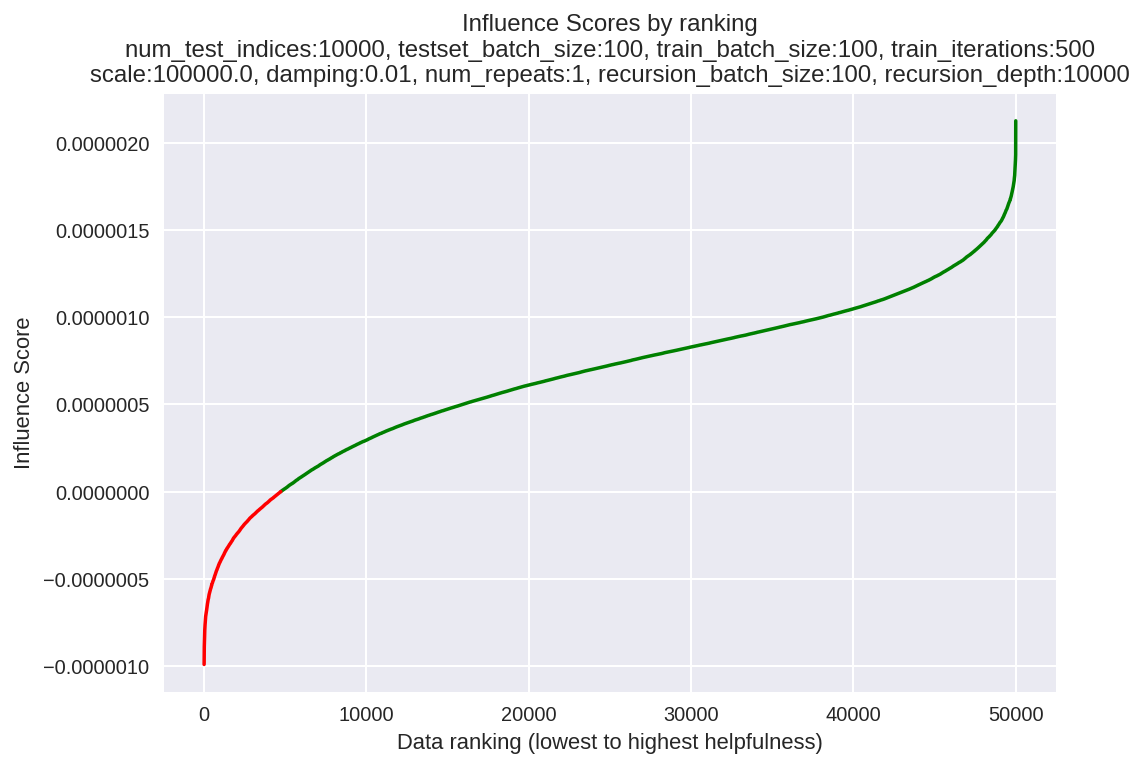

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

pos_signal = scores[sorted_indices].copy()
neg_signal = scores[sorted_indices].copy()

pos_signal[pos_signal <= 0] = np.nan
neg_signal[neg_signal > 0] = np.nan

#plotting
plt.style.use('seaborn')
plt.plot(pos_signal, color='g')
plt.plot(neg_signal, color='r')
plt.xlabel("Data ranking (lowest to highest helpfulness)")
plt.ylabel("Influence Score")
plt.title("Influence Scores by ranking\nnum_test_indices:{}, testset_batch_size:{}, train_batch_size:{}, train_iterations:{}\nscale:{}, damping:{}, num_repeats:{}, recursion_batch_size:{}, recursion_depth:{}".format(
    len(test_indices),
    testset_batch_size,
    train_batch_size,
    train_iterations,
    approx_params['scale'],
    approx_params['damping'],
    approx_params['num_repeats'],
    approx_params['recursion_batch_size'],
    approx_params['recursion_depth']))
plt.savefig('pos_neg.png', dpi=1000)
plt.show()

In [0]:
import pandas as pd

influence_results = pd.DataFrame(
    data=np.transpose(
        np.stack(
            [scores[sorted_indices],
             [i.astype(int) for i in sorted_indices],
             [i.astype(int) for i in feeder.train_origin_label[sorted_indices]],
             np.arange(len(scores),0,-1),
             np.arange(1,len(scores)+1,1)
            ])),
    columns=["score", "index", "label", "pos_rank", "neg_rank"])

In [0]:
#@title Plotting functions for interactive visualization
import numpy as np # we will use this later, so import it now

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.models import (
    ColumnDataSource,
    ColorBar,
    LinearColorMapper,
    LogColorMapper,
)
from bokeh.models.annotations import BoxAnnotation
from bokeh.models.tools import HoverTool
from bokeh.palettes import Viridis3, Viridis256
from bokeh.plotting import figure
from bokeh.transform import transform

output_notebook()

# Create a ColumnDataSource from df: source
source = ColumnDataSource(influence_results)

TOOLS = "box_select,lasso_select,help,pan,wheel_zoom,box_zoom,reset"
TITLE = "Influence scores for training data (colored and ordered by helpfulness)"

p = figure(tools=TOOLS, toolbar_location="above",
           plot_width=800, plot_height=400, title=TITLE)
p.toolbar.logo = "normal"

color_mapper = LinearColorMapper(palette=Viridis256, 
                                 low=np.min(influence_results['score'].values), 
                                 high=np.max(influence_results['score'].values))
#color_mapper.low_color = 'red'
#color_mapper.high_color = 'red'

# region that always fills the top of the plot
upper = BoxAnnotation(bottom=0, fill_alpha=0.025, fill_color='green')
p.add_layout(upper)

# region that always fills the bottom of the plot
lower = BoxAnnotation(top=0, fill_alpha=0.025, fill_color='firebrick')
p.add_layout(lower)

color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
p.add_layout(color_bar, 'right')

# add a circle renderer with x and y coordinates, size, color, and alpha
cr = p.circle('index', 'score', size=5,
              fill_color={'field': 'score', 'transform': color_mapper}, 
              hover_fill_color="orange",
              line_color={'field': 'score', 'transform': color_mapper}, 
              hover_line_color="orange",
              fill_alpha=1.0, hover_fill_alpha=1.0, source=source)

p.add_tools(HoverTool(tooltips=[("score", "@score"),
                                ('index', '@index'),
                                ("label", "@label"),
                                ('pos_rank', '@pos_rank'),
                                ("neg_rank", "@neg_rank")],
                      renderers=[cr],
                      mode='mouse'))

p.outline_line_width = 3
p.outline_line_alpha = 0.15
p.outline_line_color = "navy"
p.xaxis.axis_label = 'Index (unranked)'
p.yaxis.axis_label = 'Influence Score'

show(p)

Loading BokehJS ...

In [0]:
#@title Organizing indexes by rank

output_notebook()

# Create a ColumnDataSource from df: source
source = ColumnDataSource(influence_results)

TOOLS = "box_select,lasso_select,help,pan,wheel_zoom,box_zoom,reset"
TITLE = "Influence scores for training data (colored and ordered by helpfulness)"

p = figure(tools=TOOLS, toolbar_location="above",
           plot_width=800, plot_height=400, title=TITLE)
p.toolbar.logo = "normal"

color_mapper = LinearColorMapper(palette=Viridis256, 
                                 low=np.min(influence_results['score'].values), 
                                 high=np.max(influence_results['score'].values))
#color_mapper.low_color = 'red'
#color_mapper.high_color = 'red'

# region that always fills the top of the plot
upper = BoxAnnotation(bottom=0, fill_alpha=0.025, fill_color='green')
p.add_layout(upper)

# region that always fills the bottom of the plot
lower = BoxAnnotation(top=0, fill_alpha=0.025, fill_color='firebrick')
p.add_layout(lower)

color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
p.add_layout(color_bar, 'right')

# add a circle renderer with x and y coordinates, size, color, and alpha
cr = p.circle('neg_rank', 'score', size=5,
              fill_color={'field': 'score', 'transform': color_mapper}, 
              hover_fill_color="orange",
              line_color={'field': 'score', 'transform': color_mapper}, 
              hover_line_color="orange",
              fill_alpha=1.0, hover_fill_alpha=1.0, source=source)

p.add_tools(HoverTool(tooltips=[("score", "@score"),
                                ('index', '@index'),
                                ("label", "@label"),
                                ('pos_rank', '@pos_rank'),
                                ("neg_rank", "@neg_rank")],
                      renderers=[cr],
                      mode='mouse'))

p.outline_line_width = 3
p.outline_line_alpha = 0.15
p.outline_line_color = "navy"
p.xaxis.axis_label = 'Ranked Index (1=lowest score)'
p.yaxis.axis_label = 'Influence Score'

show(p)

Loading BokehJS ...

# Removing the top-100 most helpful data

We will now remove the data points with the influence scores judged to be in the top 100 most helpful (with respect to the entire training dataset)

In [0]:
helpful

array([27931, 19811, 28101, 22917, 22013, 21953, 28041, 14157, 37079,
       13547, 25305, 19419, 37723, 39093, 36213, 21907, 29395, 24429,
       39906, 30668, 19491,  9544, 34356, 15590, 48263, 19861, 10523,
       28456, 25383, 28647, 19787, 10204, 48670, 38865,  5319,  8901,
       24985, 11019, 45061, 14165, 26055,  3565, 27985, 38929, 22752,
        7272, 12796, 36549, 48419, 31476, 28125, 19547,  5475,  6857,
       12575,  6875, 43884,  6065, 35004, 34451, 42759, 29409,  6968,
       46944, 42637, 22787,  1837, 16105, 10874, 20662, 19361, 47816,
       16151, 39155, 13286, 28403, 28627, 40888,  8653, 19535,  5692,
       48715, 10363, 35700, 36679,  6023,  4539,  6141, 42559, 20225,
       28151, 34553, 38729, 23521, 44979, 27893, 42795,  4655, 18599,
       35516])

In [0]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.asarray([i for j, i in enumerate(x_train) if j not in harmful])
y_train = np.asarray([i for j, i in enumerate(y_train) if j not in harmful])

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (59900, 28, 28, 1)
59900 train samples
10000 test samples


Now we can retrain the MNIST CNN

In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 59900 samples, validate on 10000 samples
Epoch 1/12
59900/59900 [==============================] - 6s 96us/step - loss: 0.2655 - acc: 0.9188 - val_loss: 0.0693 - val_acc: 0.9781
Epoch 2/12
59900/59900 [==============================] - 5s 90us/step - loss: 0.0893 - acc: 0.9740 - val_loss: 0.0442 - val_acc: 0.9850
Epoch 3/12
59900/59900 [==============================] - 5s 90us/step - loss: 0.0651 - acc: 0.9811 - val_loss: 0.0399 - val_acc: 0.9863
Epoch 4/12
59900/59900 [==============================] - 5s 90us/step - loss: 0.0538 - acc: 0.9838 - val_loss: 0.0317 - val_acc: 0.9891
Epoch 5/12
59900/59900 [==============================] - 5s 90us/step - loss: 0.0457 - acc: 0.9860 - val_loss: 0.0324 - val_acc: 0.9888
Epoch 6/12
59900/59900 [==============================] - 6s 93us/step - loss: 0.0413 - acc: 0.9874 - val_loss: 0.0292 - val_acc: 0.9899
Epoch 7/12
59900/59900 [==============================] - 6s 95us/step - loss: 0.0381 - acc: 0.9890 - val_loss: 0.0286 - val_acc